# Operaciones Morfológicas para Mapas de Peso

Este notebook explora las operaciones morfológicas aplicadas a máscaras binarias de núcleos celulares para generar mapas de peso que enfaticen los bordes.

## Objetivos:
1. Entender erosión, dilatación y gradiente morfológico
2. Visualizar el efecto de diferentes elementos estructurantes
3. Implementar función para generar mapas de peso de bordes
4. Evaluar la calidad de los mapas de peso generados

In [1]:
# Importar librerías necesarias
import numpy as np
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
import os
import random

# Configuración para visualizaciones
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['axes.grid'] = False

## 1. Funciones Auxiliares para Carga de Datos

In [2]:
def load_sample_data(data_dir='../data', n_samples=3):
    """
    Carga muestras aleatorias del dataset para experimentación.
    
    Args:
        data_dir: Directorio base de los datos
        n_samples: Número de muestras a cargar
        
    Returns:
        Lista de tuplas (sample_id, image, mask)
    """
    data_path = Path(data_dir)
    
    # Obtener directorios de muestras
    sample_dirs = [d for d in data_path.iterdir() if d.is_dir()]
    
    # Seleccionar muestras aleatorias
    selected_samples = random.sample(sample_dirs, min(n_samples, len(sample_dirs)))
    
    samples = []
    for sample_dir in selected_samples:
        image_path = sample_dir / 'image.png'
        mask_path = sample_dir / 'mask.png'
        
        if image_path.exists() and mask_path.exists():
            # Cargar imagen y máscara
            image = cv2.imread(str(image_path))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
            
            samples.append((sample_dir.name, image, mask))
    
    return samples

# Cargar muestras de ejemplo
samples = load_sample_data(n_samples=3)
print(f"Cargadas {len(samples)} muestras para análisis")
for sample_id, _, _ in samples:
    print(f"- {sample_id}")

Cargadas 3 muestras para análisis
- 01711
- 00726
- 01962


## 2. Implementación de Operaciones Morfológicas Básicas

In [3]:
def apply_morphology(mask, operation='erosion', kernel_size=3, kernel_shape='ellipse'):
    """
    Aplica operaciones morfológicas a una máscara binaria.
    
    Args:
        mask: Máscara binaria (valores 0 y 255)
        operation: Tipo de operación ('erosion', 'dilation', 'opening', 'closing', 'gradient')
        kernel_size: Tamaño del elemento estructurante
        kernel_shape: Forma del kernel ('ellipse', 'rect', 'cross')
        
    Returns:
        Imagen procesada
    """
    # Binarizar máscara (asegurar valores 0 y 255)
    binary_mask = (mask > 127).astype(np.uint8) * 255
    
    # Crear elemento estructurante
    if kernel_shape == 'ellipse':
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    elif kernel_shape == 'rect':
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, kernel_size))
    elif kernel_shape == 'cross':
        kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (kernel_size, kernel_size))
    
    # Aplicar operación morfológica
    if operation == 'erosion':
        result = cv2.erode(binary_mask, kernel, iterations=1)
    elif operation == 'dilation':
        result = cv2.dilate(binary_mask, kernel, iterations=1)
    elif operation == 'opening':
        result = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel)
    elif operation == 'closing':
        result = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)
    elif operation == 'gradient':
        result = cv2.morphologyEx(binary_mask, cv2.MORPH_GRADIENT, kernel)
    else:
        raise ValueError(f"Operación no reconocida: {operation}")
    
    return result

print("✅ Funciones de operaciones morfológicas implementadas")

✅ Funciones de operaciones morfológicas implementadas


## 3. Visualización de Operaciones Morfológicas

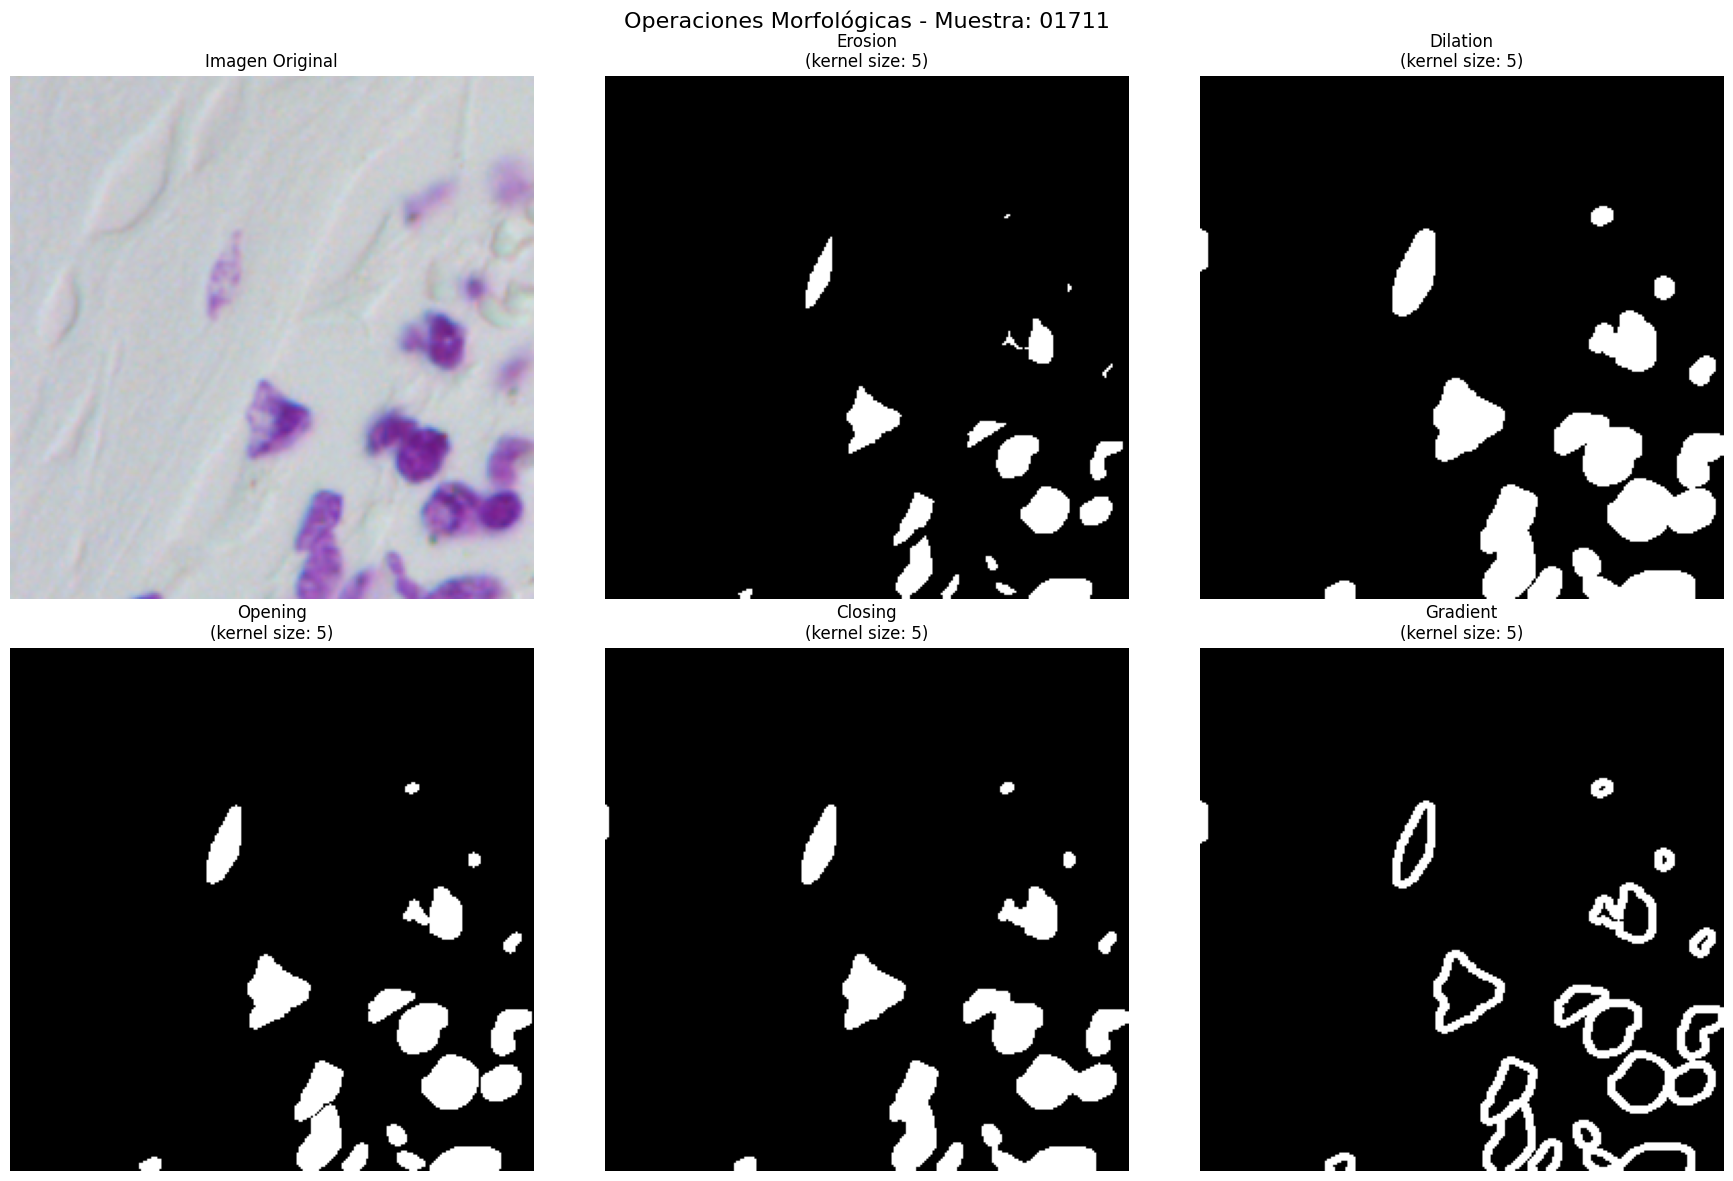

In [4]:
def visualize_morphological_operations(sample_id, image, mask):
    """
    Visualiza diferentes operaciones morfológicas aplicadas a una máscara.
    """
    operations = ['erosion', 'dilation', 'opening', 'closing', 'gradient']
    kernel_size = 5  # Elemento estructurante de tamaño 5x5
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    # Mostrar imagen original
    axes[0].imshow(image)
    axes[0].set_title('Imagen Original')
    axes[0].axis('off')
    
    # Aplicar y mostrar cada operación morfológica
    for i, operation in enumerate(operations, 1):
        result = apply_morphology(mask, operation=operation, kernel_size=kernel_size)
        
        axes[i].imshow(result, cmap='gray')
        axes[i].set_title(f'{operation.capitalize()}\n(kernel size: {kernel_size})')
        axes[i].axis('off')
    
    plt.suptitle(f'Operaciones Morfológicas - Muestra: {sample_id}', fontsize=16)
    plt.tight_layout()
    plt.show()

# Visualizar operaciones en la primera muestra
if samples:
    sample_id, image, mask = samples[0]
    visualize_morphological_operations(sample_id, image, mask)

## 4. Análisis del Gradiente Morfológico

El gradiente morfológico es especialmente útil para detectar bordes de objetos. 
Matemáticamente: **Gradiente = Dilatación - Erosión**

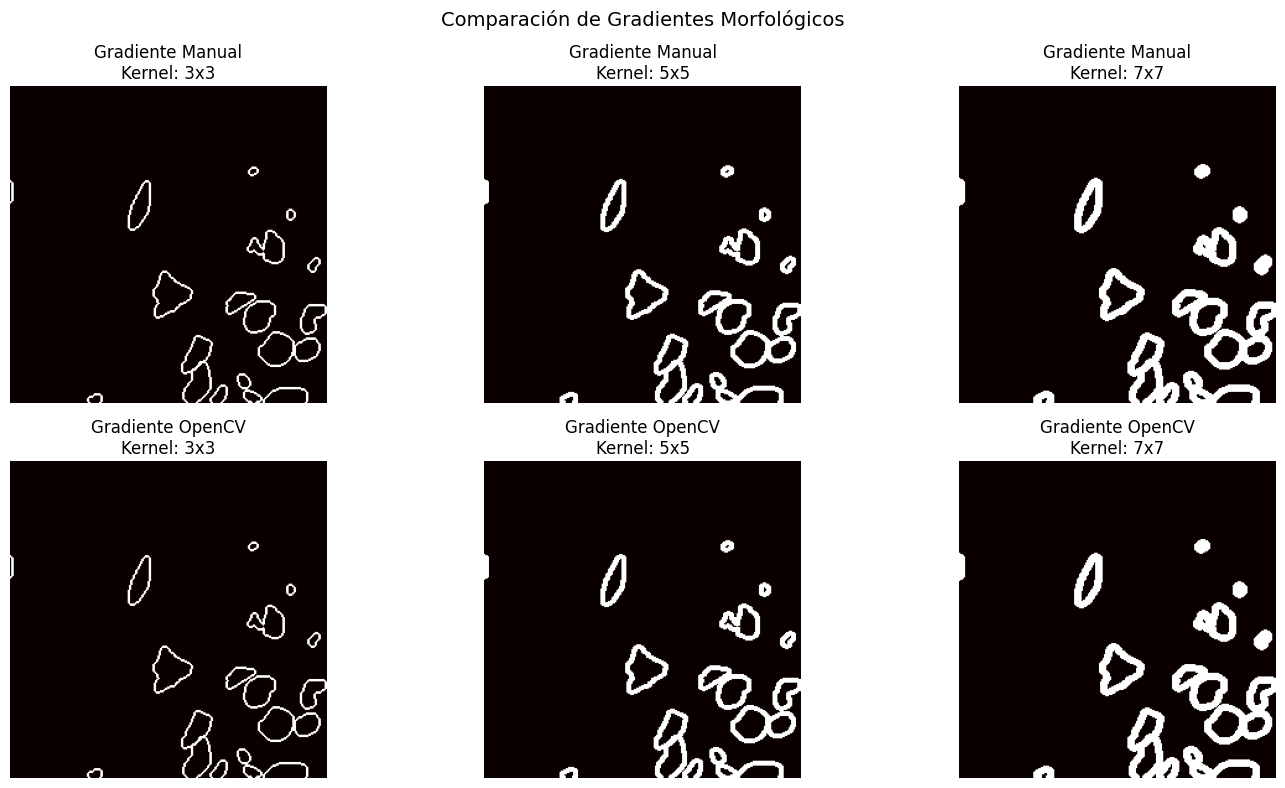

In [5]:
def analyze_morphological_gradient(mask, kernel_sizes=[3, 5, 7]):
    """
    Analiza el efecto del tamaño del kernel en el gradiente morfológico.
    """
    fig, axes = plt.subplots(2, len(kernel_sizes), figsize=(15, 8))
    
    for i, kernel_size in enumerate(kernel_sizes):
        # Calcular erosión y dilatación por separado
        erosion = apply_morphology(mask, 'erosion', kernel_size)
        dilation = apply_morphology(mask, 'dilation', kernel_size)
        
        # Calcular gradiente manualmente para mayor control
        gradient_manual = dilation.astype(np.int16) - erosion.astype(np.int16)
        gradient_manual = np.clip(gradient_manual, 0, 255).astype(np.uint8)
        
        # Calcular gradiente usando OpenCV
        gradient_cv = apply_morphology(mask, 'gradient', kernel_size)
        
        # Mostrar resultados
        axes[0, i].imshow(gradient_manual, cmap='hot')
        axes[0, i].set_title(f'Gradiente Manual\nKernel: {kernel_size}x{kernel_size}')
        axes[0, i].axis('off')
        
        axes[1, i].imshow(gradient_cv, cmap='hot')
        axes[1, i].set_title(f'Gradiente OpenCV\nKernel: {kernel_size}x{kernel_size}')
        axes[1, i].axis('off')
    
    plt.suptitle('Comparación de Gradientes Morfológicos', fontsize=14)
    plt.tight_layout()
    plt.show()

# Analizar gradiente morfológico en la primera muestra
if samples:
    _, _, mask = samples[0]
    analyze_morphological_gradient(mask)

## 5. Implementación de Mapas de Peso para Bordes

Los mapas de peso asignan mayor importancia a los píxeles de borde durante el entrenamiento, 
ayudando al modelo a aprender a distinguir mejor entre núcleos que se tocan.

In [6]:
def create_edge_weight_map(mask, background_weight=0.1, foreground_weight=1.0, edge_weight=5.0, kernel_size=5):
    """
    Crea un mapa de peso que enfatiza los bordes de los núcleos.
    
    Args:
        mask: Máscara binaria de núcleos
        background_weight: Peso para píxeles de fondo
        foreground_weight: Peso para píxeles de primer plano (núcleos)
        edge_weight: Peso para píxeles de borde
        kernel_size: Tamaño del kernel para detectar bordes
        
    Returns:
        weight_map: Mapa de pesos del mismo tamaño que la máscara
    """
    # Binarizar máscara
    binary_mask = (mask > 127).astype(np.uint8)
    
    # Calcular gradiente morfológico para detectar bordes
    edges = apply_morphology(mask, 'gradient', kernel_size)
    edges_binary = (edges > 0).astype(np.uint8)
    
    # Inicializar mapa de pesos
    weight_map = np.full(mask.shape, background_weight, dtype=np.float32)
    
    # Asignar pesos según la región
    # Primer plano (núcleos)
    weight_map[binary_mask == 1] = foreground_weight
    
    # Bordes (mayor prioridad)
    weight_map[edges_binary == 1] = edge_weight
    
    return weight_map, edges

def visualize_weight_map(sample_id, image, mask, weight_map, edges):
    """
    Visualiza el mapa de pesos generado junto con la imagen original.
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Imagen original
    axes[0, 0].imshow(image)
    axes[0, 0].set_title('Imagen Original')
    axes[0, 0].axis('off')
    
    # Máscara binaria
    axes[0, 1].imshow(mask, cmap='gray')
    axes[0, 1].set_title('Máscara Binaria')
    axes[0, 1].axis('off')
    
    # Bordes detectados
    axes[1, 0].imshow(edges, cmap='hot')
    axes[1, 0].set_title('Bordes Detectados\n(Gradiente Morfológico)')
    axes[1, 0].axis('off')
    
    # Mapa de pesos
    im = axes[1, 1].imshow(weight_map, cmap='viridis')
    axes[1, 1].set_title('Mapa de Pesos\n(Bordes = Mayor Peso)')
    axes[1, 1].axis('off')
    
    # Añadir barra de colores para el mapa de pesos
    plt.colorbar(im, ax=axes[1, 1], fraction=0.046, pad=0.04)
    
    plt.suptitle(f'Mapa de Pesos para Bordes - Muestra: {sample_id}', fontsize=14)
    plt.tight_layout()
    plt.show()

print("✅ Funciones de mapas de peso implementadas")

✅ Funciones de mapas de peso implementadas


## 6. Aplicación y Evaluación de Mapas de Peso


Generando mapa de peso para muestra: 01711


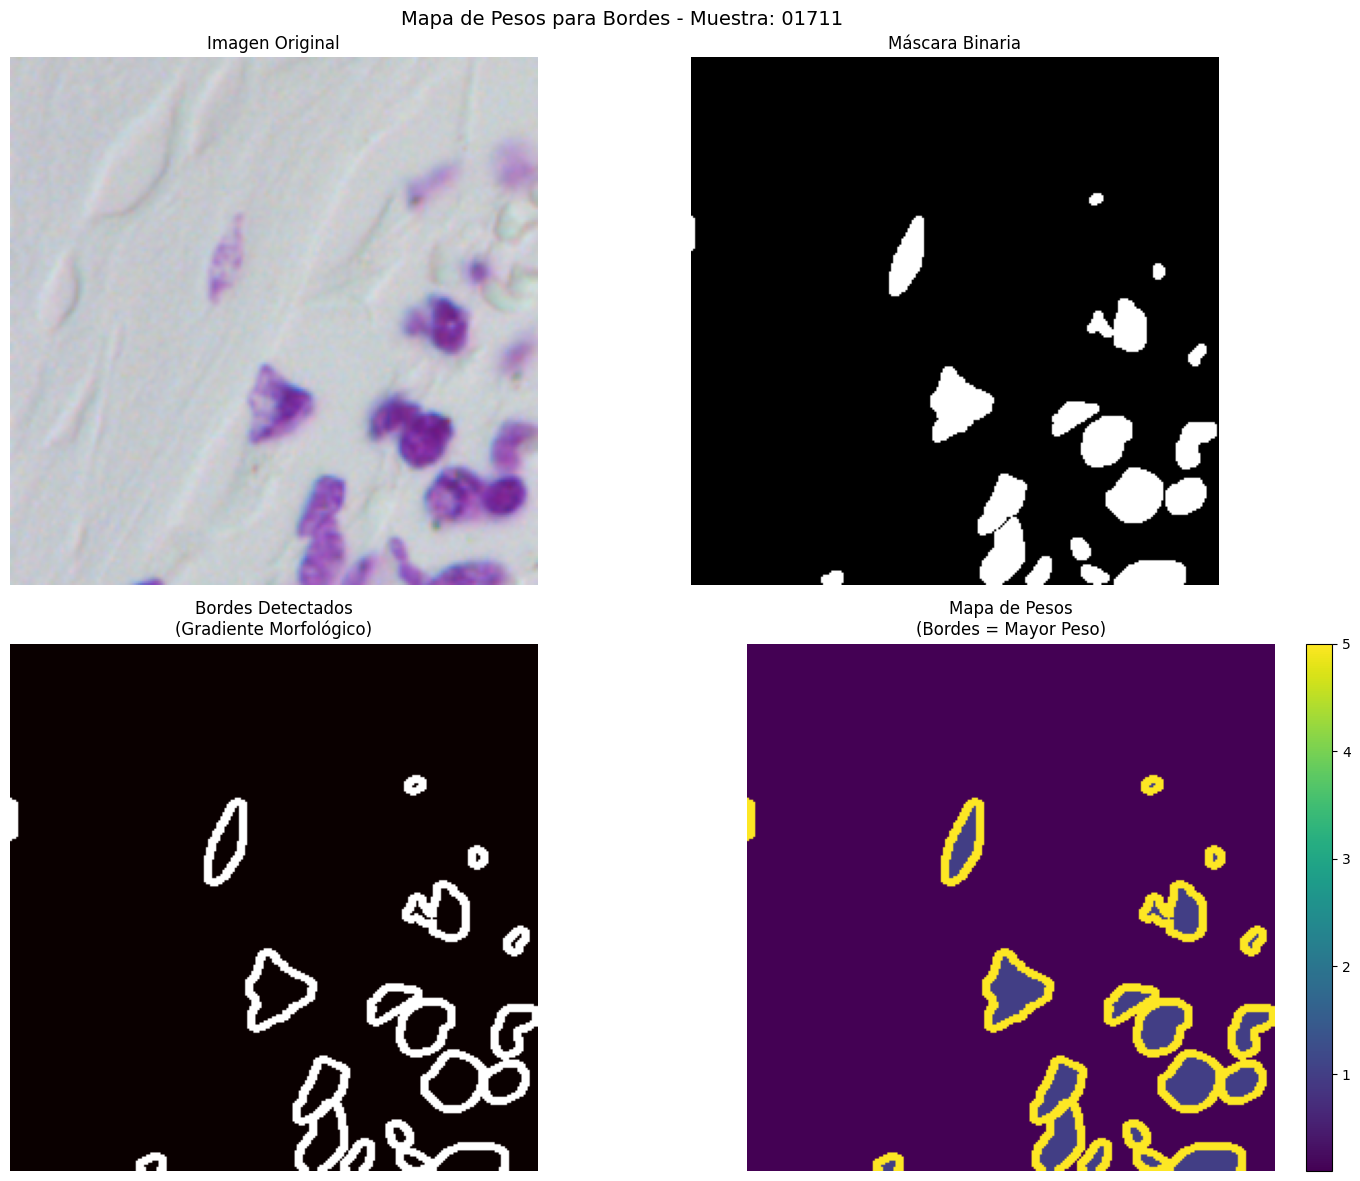

Estadísticas del mapa de peso:
  - Valor mínimo: 0.10
  - Valor máximo: 5.00
  - Valor promedio: 0.47
  - Píxeles de borde: 4,409
  - Porcentaje de bordes: 6.73%

Generando mapa de peso para muestra: 00726


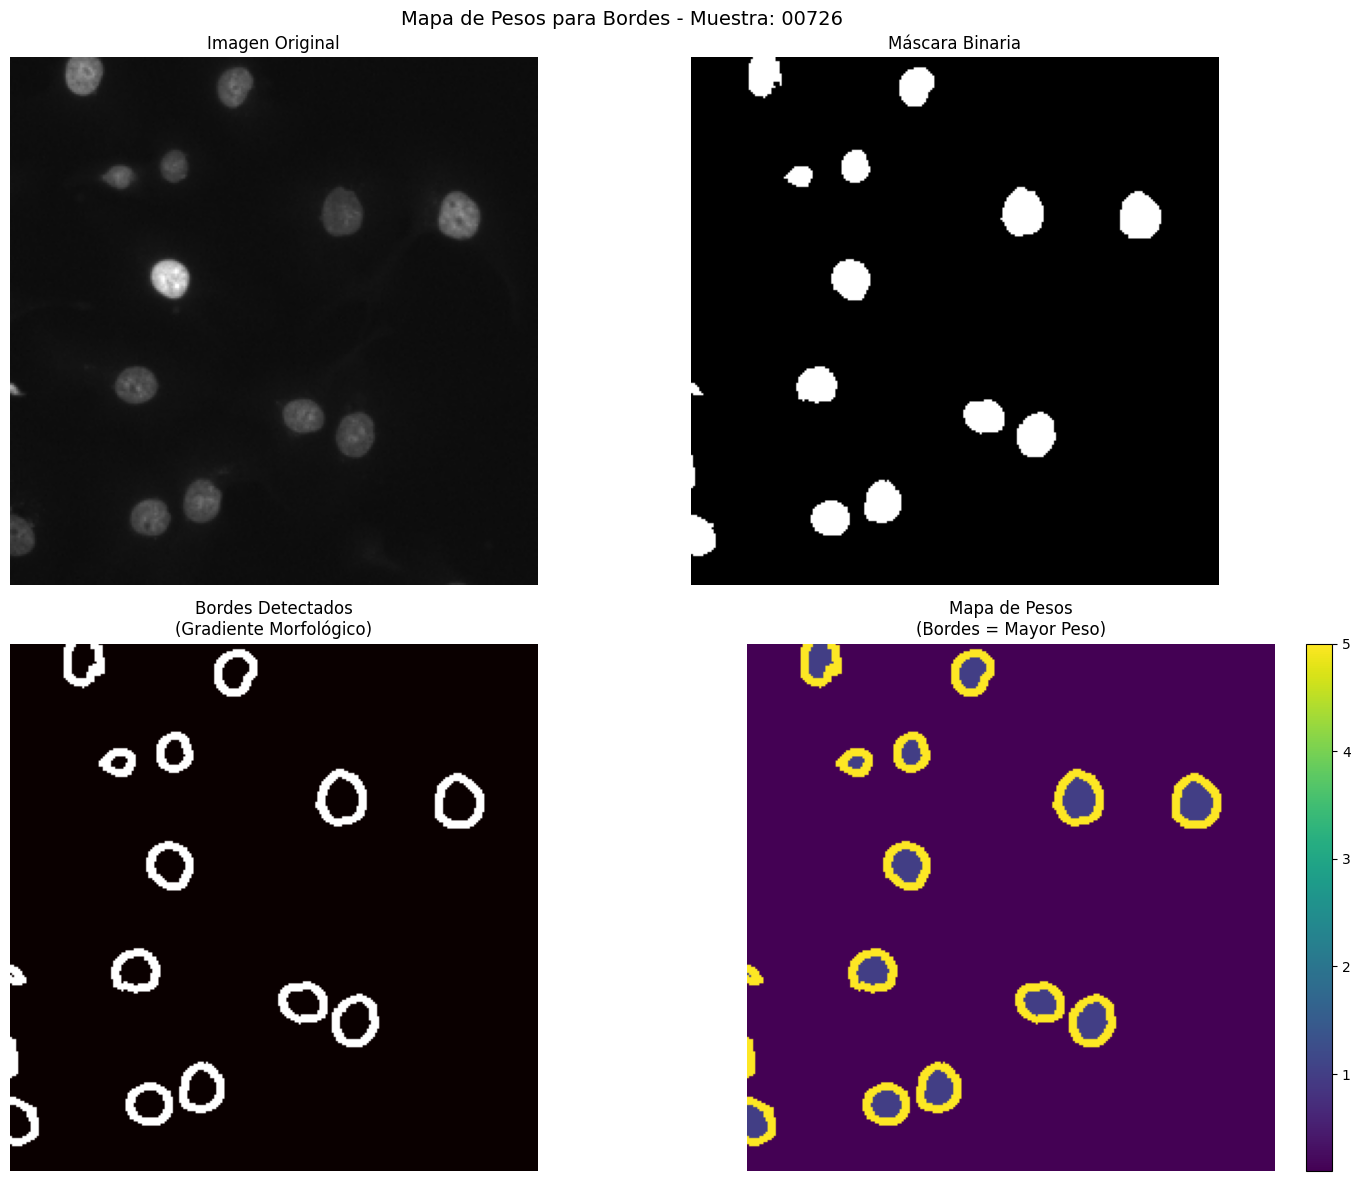

Estadísticas del mapa de peso:
  - Valor mínimo: 0.10
  - Valor máximo: 5.00
  - Valor promedio: 0.36
  - Píxeles de borde: 3,158
  - Porcentaje de bordes: 4.82%

Generando mapa de peso para muestra: 01962


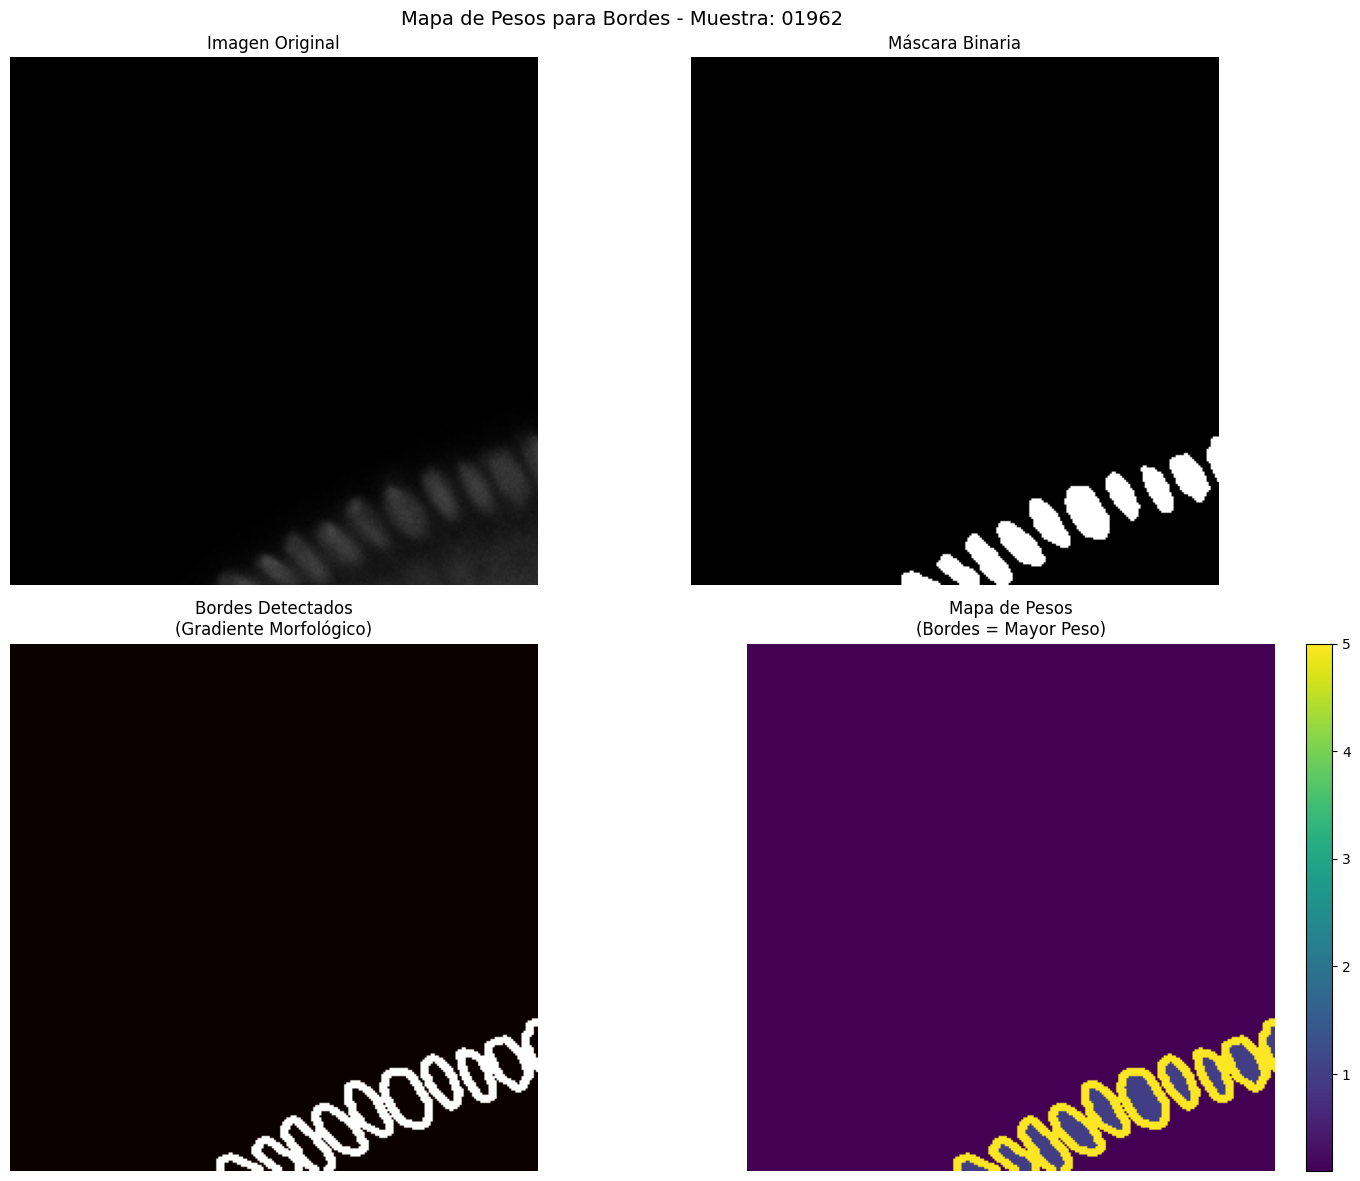

Estadísticas del mapa de peso:
  - Valor mínimo: 0.10
  - Valor máximo: 5.00
  - Valor promedio: 0.29
  - Píxeles de borde: 2,359
  - Porcentaje de bordes: 3.60%


In [7]:
# Generar y visualizar mapas de peso para todas las muestras
for sample_id, image, mask in samples:
    print(f"\nGenerando mapa de peso para muestra: {sample_id}")
    
    # Crear mapa de peso
    weight_map, edges = create_edge_weight_map(
        mask, 
        background_weight=0.1, 
        foreground_weight=1.0, 
        edge_weight=5.0, 
        kernel_size=5
    )
    
    # Visualizar resultados
    visualize_weight_map(sample_id, image, mask, weight_map, edges)
    
    # Estadísticas del mapa de peso
    print(f"Estadísticas del mapa de peso:")
    print(f"  - Valor mínimo: {weight_map.min():.2f}")
    print(f"  - Valor máximo: {weight_map.max():.2f}")
    print(f"  - Valor promedio: {weight_map.mean():.2f}")
    print(f"  - Píxeles de borde: {(edges > 0).sum():,}")
    print(f"  - Porcentaje de bordes: {100 * (edges > 0).sum() / edges.size:.2f}%")

## 7. Experimentos con Diferentes Parámetros

Comparando diferentes tamaños de kernel:
Kernel 3x3: 1,965 píxeles de borde
Kernel 5x5: 4,409 píxeles de borde
Kernel 7x7: 6,211 píxeles de borde
Kernel 9x9: 8,248 píxeles de borde


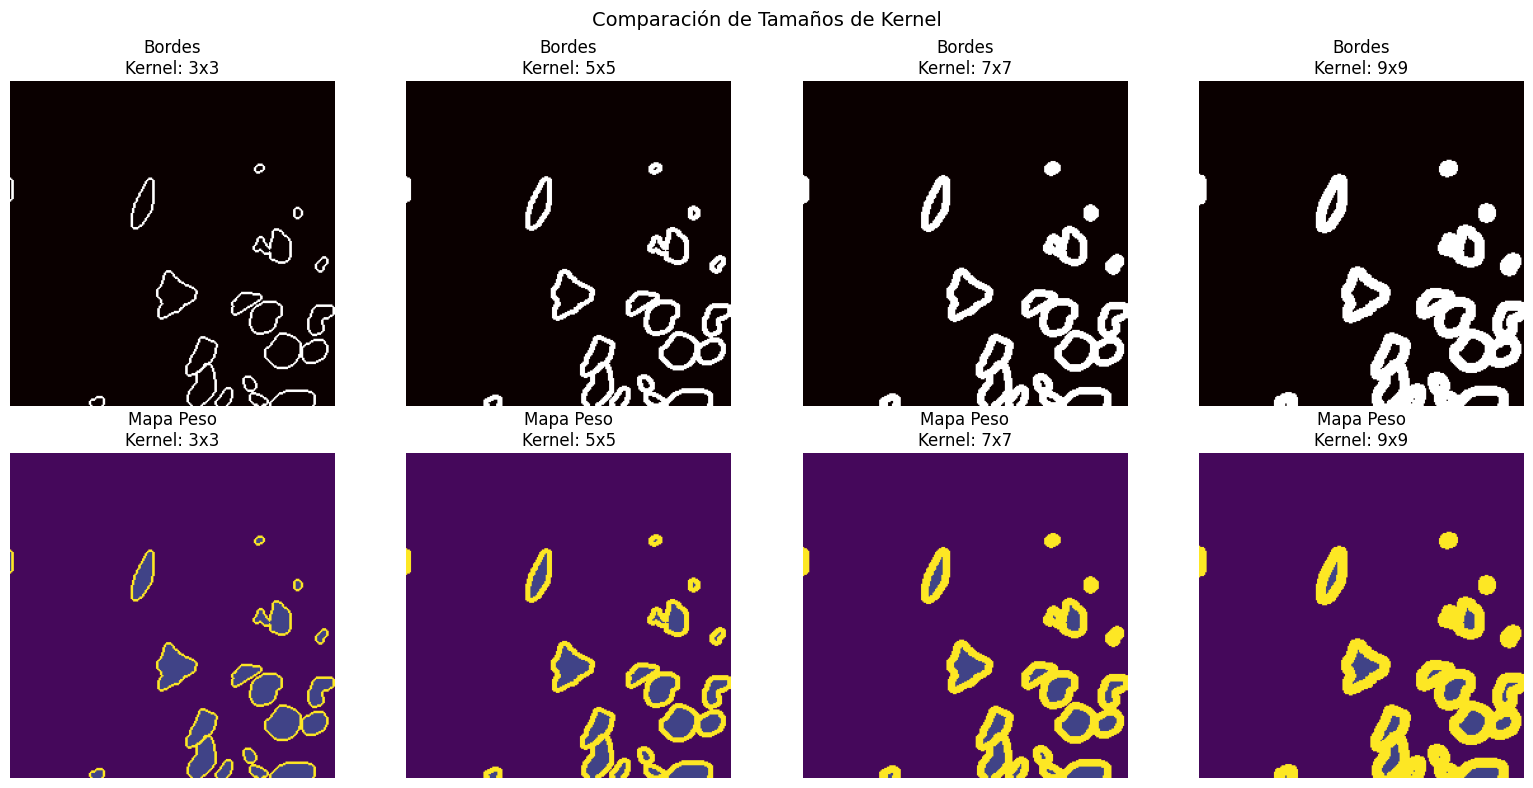

In [8]:
def compare_kernel_sizes(mask, kernel_sizes=[3, 5, 7, 9]):
    """
    Compara el efecto de diferentes tamaños de kernel en la detección de bordes.
    """
    fig, axes = plt.subplots(2, len(kernel_sizes), figsize=(16, 8))
    
    for i, kernel_size in enumerate(kernel_sizes):
        # Generar mapa de peso
        weight_map, edges = create_edge_weight_map(mask, kernel_size=kernel_size)
        
        # Mostrar bordes
        axes[0, i].imshow(edges, cmap='hot')
        axes[0, i].set_title(f'Bordes\nKernel: {kernel_size}x{kernel_size}')
        axes[0, i].axis('off')
        
        # Mostrar mapa de peso
        im = axes[1, i].imshow(weight_map, cmap='viridis', vmin=0, vmax=5)
        axes[1, i].set_title(f'Mapa Peso\nKernel: {kernel_size}x{kernel_size}')
        axes[1, i].axis('off')
        
        # Estadísticas
        edge_pixels = (edges > 0).sum()
        print(f"Kernel {kernel_size}x{kernel_size}: {edge_pixels:,} píxeles de borde")
    
    plt.suptitle('Comparación de Tamaños de Kernel', fontsize=14)
    plt.tight_layout()
    plt.show()

# Comparar diferentes tamaños de kernel en la primera muestra
if samples:
    _, _, mask = samples[0]
    print("Comparando diferentes tamaños de kernel:")
    compare_kernel_sizes(mask)

## 8. Función Final para Generación de Mapas de Peso

Esta función integra todo lo aprendido en una implementación lista para usar en el pipeline de datos.

In [9]:
def generate_training_weights(image, mask, 
                            background_weight=0.1, 
                            foreground_weight=1.0, 
                            edge_weight=5.0,
                            edge_kernel_size=5):
    """
    Función completa para generar mapa de pesos optimizado para entrenamiento.
    
    Esta función será integrada en el Dataset de PyTorch.
    
    Args:
        image: Imagen RGB original (no utilizada directamente, pero disponible)
        mask: Máscara binaria de núcleos (valores 0-255)
        background_weight: Peso para píxeles de fondo
        foreground_weight: Peso para píxeles de núcleos
        edge_weight: Peso para píxeles de borde (más alto = más importante)
        edge_kernel_size: Tamaño del kernel para detección de bordes
        
    Returns:
        tuple: (weight_map, edge_mask)
            - weight_map: Mapa de pesos (float32)
            - edge_mask: Máscara binaria de bordes para análisis
    """
    # Crear mapa de peso usando la función implementada
    weight_map, edge_mask = create_edge_weight_map(
        mask=mask,
        background_weight=background_weight,
        foreground_weight=foreground_weight,
        edge_weight=edge_weight,
        kernel_size=edge_kernel_size
    )
    
    return weight_map, edge_mask

print("✅ Función final de generación de mapas de peso implementada")
print("✅ Lista para integración en el Dataset de PyTorch")

✅ Función final de generación de mapas de peso implementada
✅ Lista para integración en el Dataset de PyTorch


## 9. Resumen y Conclusiones

### Lo que hemos logrado:

1. **Operaciones Morfológicas**: Implementamos erosión, dilatación, apertura, cierre y gradiente morfológico

2. **Detección de Bordes**: Utilizamos gradiente morfológico para identificar bordes de núcleos

3. **Mapas de Peso**: Creamos mapas que priorizan bordes durante el entrenamiento

4. **Experimentación**: Evaluamos diferentes tamaños de kernel y parámetros

### Parámetros Recomendados:
- **Kernel Size**: 5x5 (buen balance entre detección y ruido)
- **Pesos**: Fondo=0.1, Núcleos=1.0, Bordes=5.0
- **Elemento Estructurante**: Elíptico (mejor para formas orgánicas)
